<a href="https://colab.research.google.com/github/trngbro/AI/blob/main/Progress20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

init

# Upload input if not exist

Chạy đoạn mã dưới đây, ngay sau khi xuất hiện **Choose Files** thì lập tức bấm vào và chọn file txt input để chạy thuật toán. Sau quá trình tải lên (đạt 100% trạng thái) thì sẽ xuất ra màn hình thông tin file tải lên. Kiểm tra và chắc chắn là tải lên đúng file.

Có thể lấy file mẫu tại đây: *`matrix.txt`*

Cũng có thể kiểm tra rằng file đã tải lên hay chưa bằng cách kiểm tra có file matrix.txt tồn tại ở folder colab hay chưa (hình minh hoạ đính kèm).
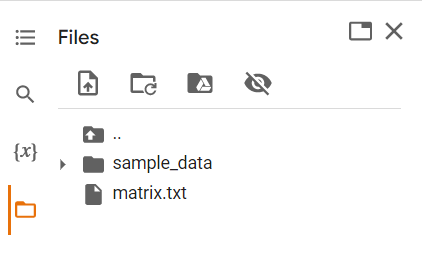

In [4]:
import os.path
from google.colab import files

if not (os.path.isfile("matrix.txt")):
  uploaded = files.upload()
  file_name = "matrix.txt"
with open('matrix.txt', 'r') as f:
  data = f.readlines()
  print("Các dòng đầu của file:")
  for line in data[:8]:
      print(line)

Saving matrix.txt to matrix.txt
Các dòng đầu của file:
3 3

2 . 1

. . .

1 . 1


# Read file

In [10]:
def read_file():
    filename = 'matrix.txt'
    with open(filename, 'r') as f:
        lines = f.readlines()
    # Loại bỏ khoảng trắng và ký tự xuống dòng
    lines = [line.strip() for line in lines]
    # Lấy kích thước ma trận
    m, n = map(int, lines[0].split())
    # Tạo ma trận với kích thước m x n
    matrix = [[None] * n for _ in range(m)]
    # Đọc các giá trị trong ma trận
    for i in range(1, m+1):
        row = lines[i].split()
        for j in range(n):
            if row[j].isdigit():
                matrix[i-1][j] = int(row[j])
            else:
                matrix[i-1][j] = ''
    # Trả về ma trận dưới dạng mảng 2 chiều
    return matrix


In [11]:
print(read_file())

[[2, '', 1], ['', '', ''], [1, '', 1]]


# Main function

In [1]:
!pip install python-sat==0.1.7.dev12

from pysat.solvers import Glucose3
import itertools


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached python-sat-0.1.7.dev12.tar.gz (3.6 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for python-sat: filename=python_sat-0.1.7.dev12-cp310-cp310-linux_x86_64.whl size=1786459 sha256=b13355b2fc684ef5cdd9f57c01a831c0b62ba6a8383275f782c7a8e4fab55c9d
  Stored in directory: /root/.cache/pip/wheels/07/13/11/812821224beb3b5fb7169d070a1301b2b9bd118a8f95fb1ebf
Successfully built python-sat


In [2]:
from pysat.solvers import Glucose3
from itertools import combinations, product

def get_propositions(matrix):
    props = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] != '' and matrix[i][j]!=0:
                props.append((i, j))
    return props

def get_neighbors(prop, matrix):
    neighbors = []
    i, j = prop
    for x in range(max(0, i-1), min(i+2, len(matrix))):
        for y in range(max(0, j-1), min(j+2, len(matrix[0]))):
            if matrix[x][y] != '' and matrix[x][y]!=0:
                neighbors.append((x, y))
    return neighbors

# Tạo ra CNF :>> nhưng mà lạ lắm
def generate_clauses(props, matrix):
    clauses = []
    for p in props:
        neighbors = get_neighbors(p, matrix)
        num_green = matrix[p[0]][p[1]]
        for comb in combinations(neighbors, num_green):
            clause = []
            for n in neighbors:
                if n in comb:
                    clause.append(get_index(n, props) + 1)
                else:
                    clause.append(-(get_index(n, props) + 1))
            clauses.append(clause)
        if num_green == 0:
            for n in neighbors:
                clauses.append([-1 * (get_index(n, props) + 1)])
    return clauses


def get_index(prop, props):
    return props.index(prop)

def solve_puzzle(matrix):
    props = get_propositions(matrix)
    clauses = generate_clauses(props, matrix)
    with Glucose3() as solver:
        for clause in clauses:
            solver.add_clause(clause)
        res = solver.solve()
        if res == False:
            return None
        result = [['red' for j in range(len(matrix[0]))] for i in range(len(matrix))]
        for p in props:
            if solver.get_model()[get_index(p, props)] > 0:
                result[p[0]][p[1]] = 'green'
        return result

# Test

In [12]:
# Test the function with example input
matrix = (read_file())



print(solve_puzzle(matrix))

print(get_neighbors((1,1),matrix))

[['red', 'red', 'green'], ['red', 'red', 'red'], ['green', 'red', 'green']]
[(0, 0), (0, 2), (2, 0), (2, 2)]


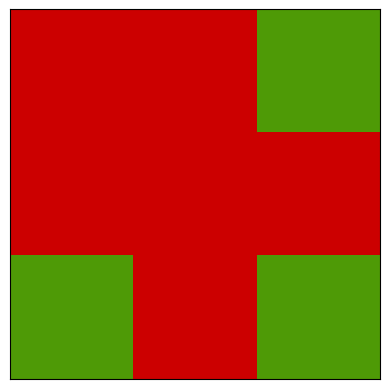

In [17]:
import matplotlib.pyplot as plt

matrix_color = solve_puzzle(matrix)

color_map = {'red': (204, 0, 0), 'green': (78, 154, 6)}
colors = [[color_map[val] for val in row] for row in matrix_color]

fig, ax = plt.subplots()

ax.set_xticks([])
ax.set_yticks([])

ax.imshow(colors)

plt.show()


In [ ]:
_matrix = [
	['',  2,  3, '', '',  0, '', '', '', ''],
	['', '', '', '',  3, '',  2, '', '',  6],
	['', '',  5, '',  5,  3, '',  5,  7,  4],
	['',  4, '',  5, '',  5, '',  6, '',  3],
	['', '',  4, '',  5, '',  6, '', '',  3],
	['', '', '',  2, '',  5, '', '', '', ''],
	[ 4, '',  1, '', '', '',  1,  1, '', ''],
	[ 4, '',  1, '', '', '',  1, '',  4, ''],
	['', '', '', '',  6, '', '', '', '',  4],
	['',  4,  4, '', '', '', '',  4, '', '']
] 

'''
[
	[R, G, G, R, R, R, R, R, G, G],
	[R, R, R, G, R, R, R, G, G, G],
	[R, R, G, G, G, R, R, G, G, G],
	[R, G, G, R, G, G, R, G, R, R],
	[R, G, R, R, R, G, G, G, G, R],
	[G, G, R, R, G, G, R, R, G, G],
	[G, R, R, R, G, R, R, R, R, G],
	[G, R, R, R, G, R, R, R, R, G],
	[G, G, R, R, G, G, R, R, G, G],
	[R, G, G, G, G, G, G, G, G, R]
] 
'''